In [1]:
from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import datasets
import os
import torch
import numpy as np
import pandas as pd
from MicroBiome import MicroBiomeDataSet, Trainer, TrainTester, MultiTrainTester
from SNN import FeedForward, SiameseDataSet, SiameseModel, seed_everything
import seaborn as sns
import matplotlib.pyplot as plt   
import numpy as np
import random

# Ignore warning messages
if True:
    import warnings
    warnings.filterwarnings('ignore')

# Load Data

In [2]:
top_dir = '/project'
data_dir = os.path.join(top_dir, 'data')
preproc_dir = os.path.join(data_dir, 'preprocessed')
inp_dir = os.path.join(preproc_dir, 'Gupta_2020_Precompiled_Cleaned')
os.listdir(inp_dir)

['MatrixDataClean.csv', 'SampleMetaDataClean.csv', 'FeatMetaDataClean.csv']

In [3]:
SampleMeta = pd.read_csv(os.path.join(inp_dir, 'SampleMetaDataClean.csv'))
SampleMeta.head()

,6,study,Study No. (From VG sheet (V-*) from SB sheet (S-*)),Title of Paper,Author (year),Journal,Study Accession,Sample Accession or Sample ID,Sample title (ENA/SRA),Sample title (Paper),...,Use of milk or milk products (Yes/No/Sometimes),Use of Animal Product- Meat (Yes/No/Vegetarian/Vegan),Alcohol Consumption (Yes/No),Diet1,Intervention for study (Diet),Intervention for study (medication),Sequencing Platform,Library layout (SINGLE/PAIRED),Read count after Quality control,Healthy
0,SAMEA104142287,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142287,ZSL-004,ZSL-004,...,NaN,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,43356775.0,Unhealthy
1,SAMEA104142288,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142288,ZSL-007,ZSL-007,...,NaN,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,41073871.0,Unhealthy
2,SAMEA104142293,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142293,ZSL-010,ZSL-010,...,NaN,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,40199673.0,Unhealthy
3,SAMEA104142291,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142291,ZSL-011,ZSL-011,...,NaN,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,31054158.0,Unhealthy
4,SAMEA104142284,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142284,ZSL-019,ZSL-019,...,NaN,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,36081150.0,Unhealthy


In [4]:
filter_indices = SampleMeta["Phenotype"].isin(['ACVD', 'CRC', 'Crohns disease', 'Healthy'])
SampleMeta = SampleMeta[ filter_indices ]
SampleMeta.shape

(3153, 34)

In [5]:
MatrixData = np.loadtxt(os.path.join(inp_dir, 'MatrixDataClean.csv'))
MatrixData = MatrixData[filter_indices, :]
MatrixData.shape

(3153, 903)

In [6]:
X = MatrixData

In [7]:
FeatMeta = pd.read_csv(os.path.join(inp_dir, 'FeatMetaDataClean.csv'))
FeatMeta

,Unnamed: 0,feature
0,s__Abiotrophia_defectiva,s__Abiotrophia_defectiva
1,s__Acetobacter_unclassified,s__Acetobacter_unclassified
2,s__Achromobacter_piechaudii,s__Achromobacter_piechaudii
3,s__Achromobacter_unclassified,s__Achromobacter_unclassified
4,s__Achromobacter_xylosoxidans,s__Achromobacter_xylosoxidans
...,...,...
898,s__Weissella_koreensis,s__Weissella_koreensis
899,s__Weissella_paramesenteroides,s__Weissella_paramesenteroides
900,s__Weissella_unclassified,s__Weissella_unclassified
901,s__Wohlfahrtiimonas_chitiniclastica,s__Wohlfahrtiimonas_chitiniclastica


In [8]:
SampleMeta['Phenotype'].value_counts()

Healthy           2636
CRC                257
ACVD               152
Crohns disease     108
Name: Phenotype, dtype: int64

In [9]:
y = SampleMeta['Phenotype'].to_numpy()

In [10]:
y

array(['ACVD', 'ACVD', 'ACVD', ..., 'Healthy', 'Healthy', 'Healthy'],
      dtype=object)

In [11]:
OneHot = OneHotEncoder(sparse=False)
y = OneHot.fit_transform(y.reshape((y.shape[0], 1)))

In [12]:
class_map = OneHot.transform(np.array(['ACVD', 'CRC', 'Crohns disease', 'Healthy']).reshape((4, 1)))

In [13]:
# One-hot encoded classes
class_map

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [14]:
# reverse mapping back to original classes
OneHot.inverse_transform(class_map)

array([['ACVD'],
       ['CRC'],
       ['Crohns disease'],
       ['Healthy']], dtype=object)

In [15]:
y

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [16]:
y.shape

(3153, 4)

In [17]:
np.sum(y, axis=0)

array([ 152.,  257.,  108., 2636.])

In [18]:
y

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

# Quick PCA of Data

In [19]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [20]:
pca_model = PCA(n_components = None)
X_PCA = pca_model.fit_transform(X_scaled)

<AxesSubplot:>

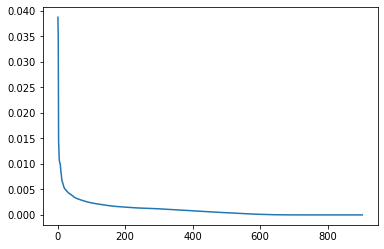

In [21]:
sns.lineplot(x = np.arange(1, len(pca_model.explained_variance_ratio_) + 1), y = pca_model.explained_variance_ratio_)

<AxesSubplot:>

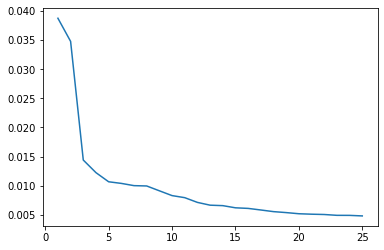

In [22]:
sns.lineplot(x = np.arange(1, 26), y = pca_model.explained_variance_ratio_[np.arange(0,25)])

<AxesSubplot:>

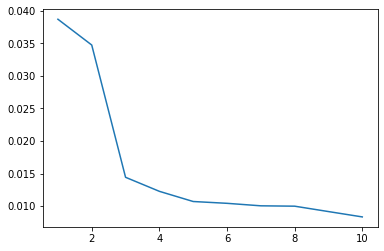

In [23]:
sns.lineplot(x = np.arange(1, 11), y = pca_model.explained_variance_ratio_[np.arange(0,10)])

<AxesSubplot:>

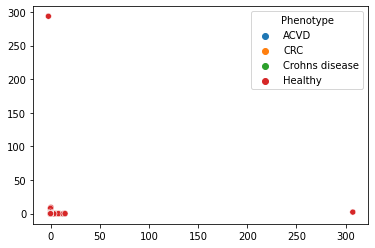

In [74]:
sns.scatterplot(x = X_PCA[:, 0], y = X_PCA[:, 1], hue = SampleMeta['Phenotype'])

<AxesSubplot:>

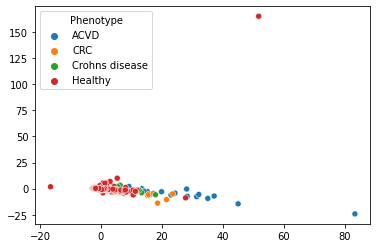

In [76]:
sns.scatterplot(x = X_PCA[:, 2], y = X_PCA[:, 3], hue = SampleMeta['Phenotype'])

<AxesSubplot:>

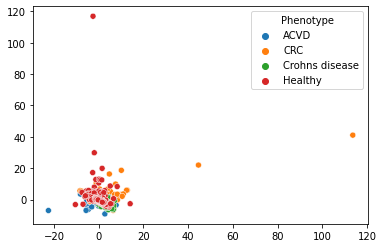

In [77]:
sns.scatterplot(x = X_PCA[:, 4], y = X_PCA[:, 5], hue = SampleMeta['Phenotype'])

# Define and Train Model

In [24]:
seed_everything(69)

In [25]:
MyFeedForward = FeedForward(10, [3, 3, 2], activation='softplus')

In [26]:
MyFeedForward

FeedForward(
  (layers): ModuleList(
    (0): Linear(in_features=20, out_features=3, bias=True)
    (1): Linear(in_features=3, out_features=3, bias=True)
    (2): Linear(in_features=3, out_features=2, bias=True)
  )
)

In [27]:
MySNN = SiameseModel(MyFeedForward, predict_unknown = False, class_min_train=5, 
                     n_example_predict=30, learning_rate=1.0e-2, num_epochs = 50, batch_size = 200, rand_seed=69)

In [28]:
# list(MySNN.logistic.parameters()) + list(MySNN.model.parameters())

In [29]:
MyTrainer = Trainer(model = MySNN, scale_X = True, use_pca = True, n_components = 10)

In [30]:
MyTrainTester = TrainTester(MyTrainer, metrics.accuracy_score)

In [31]:
n_splits = 5
MyMultiTrainTester = MultiTrainTester(MyTrainTester, n_splits=n_splits)

In [32]:
MyMultiTrainTester.train(X, y)

Running for split 1 of 5
Training Encoder
#########################################
Epoch 1 of 50
__Training__
2021-03-11 02:16:47
MEAN LOSS: 0.7037758964538574
__Validation__
2021-03-11 02:16:48
MEAN LOSS: 0.6932339307748981
#########################################
Epoch 2 of 50
__Training__
2021-03-11 02:16:48
MEAN LOSS: 0.6932146141052246
__Validation__
2021-03-11 02:16:48
MEAN LOSS: 0.693183142252595
#########################################
Epoch 3 of 50
__Training__
2021-03-11 02:16:48
MEAN LOSS: 0.6932642311096191
__Validation__
2021-03-11 02:16:49
MEAN LOSS: 0.6932001993744143
#########################################
Epoch 4 of 50
__Training__
2021-03-11 02:16:49
MEAN LOSS: 0.6932630279541016
__Validation__
2021-03-11 02:16:49
MEAN LOSS: 0.6933514610482807
#########################################
Epoch 5 of 50
__Training__
2021-03-11 02:16:49
MEAN LOSS: 0.6932381416320801
__Validation__
2021-03-11 02:16:50
MEAN LOSS: 0.6933523503431428
#######################################

MEAN LOSS: 0.6408696769714356
__Validation__
2021-03-11 02:17:13
MEAN LOSS: 0.6826749264281897
#########################################
Epoch 46 of 50
__Training__
2021-03-11 02:17:13
MEAN LOSS: 0.6375255405426026
__Validation__
2021-03-11 02:17:14
MEAN LOSS: 0.6871730622464102
#########################################
Epoch 47 of 50
__Training__
2021-03-11 02:17:14
MEAN LOSS: 0.6371048679351806
__Validation__
2021-03-11 02:17:14
MEAN LOSS: 0.6942736357852857
#########################################
Epoch 48 of 50
__Training__
2021-03-11 02:17:15
MEAN LOSS: 0.6363692222595215
__Validation__
2021-03-11 02:17:15
MEAN LOSS: 0.6856073642184776
#########################################
Epoch 49 of 50
__Training__
2021-03-11 02:17:15
MEAN LOSS: 0.6349839199066162
__Validation__
2021-03-11 02:17:16
MEAN LOSS: 0.6905276738878416
#########################################
Epoch 50 of 50
__Training__
2021-03-11 02:17:16
MEAN LOSS: 0.6370497161865234
__Validation__
2021-03-11 02:17:16
MEAN LOSS:

MEAN LOSS: 0.6586274883270263
__Validation__
2021-03-11 02:17:43
MEAN LOSS: 0.6847569159191005
#########################################
Epoch 40 of 50
__Training__
2021-03-11 02:17:43
MEAN LOSS: 0.6597804134368896
__Validation__
2021-03-11 02:17:44
MEAN LOSS: 0.6823538678063669
#########################################
Epoch 41 of 50
__Training__
2021-03-11 02:17:44
MEAN LOSS: 0.6578280113220215
__Validation__
2021-03-11 02:17:44
MEAN LOSS: 0.6873493130200624
#########################################
Epoch 42 of 50
__Training__
2021-03-11 02:17:44
MEAN LOSS: 0.6572721660614014
__Validation__
2021-03-11 02:17:45
MEAN LOSS: 0.6903050420093279
#########################################
Epoch 43 of 50
__Training__
2021-03-11 02:17:45
MEAN LOSS: 0.6558964931488037
__Validation__
2021-03-11 02:17:46
MEAN LOSS: 0.6933001034116015
#########################################
Epoch 44 of 50
__Training__
2021-03-11 02:17:46
MEAN LOSS: 0.6545201446533203
__Validation__
2021-03-11 02:17:46
MEAN LOSS:

MEAN LOSS: 0.6361590446472168
__Validation__
2021-03-11 02:18:13
MEAN LOSS: 0.6784830522580151
#########################################
Epoch 34 of 50
__Training__
2021-03-11 02:18:13
MEAN LOSS: 0.6342132484436035
__Validation__
2021-03-11 02:18:14
MEAN LOSS: 0.6795671988349042
#########################################
Epoch 35 of 50
__Training__
2021-03-11 02:18:14
MEAN LOSS: 0.6342534023284913
__Validation__
2021-03-11 02:18:14
MEAN LOSS: 0.675245006914937
#########################################
Epoch 36 of 50
__Training__
2021-03-11 02:18:14
MEAN LOSS: 0.6349655822753906
__Validation__
2021-03-11 02:18:15
MEAN LOSS: 0.6795312862585087
#########################################
Epoch 37 of 50
__Training__
2021-03-11 02:18:15
MEAN LOSS: 0.6322470359802246
__Validation__
2021-03-11 02:18:15
MEAN LOSS: 0.6860741474519003
#########################################
Epoch 38 of 50
__Training__
2021-03-11 02:18:15
MEAN LOSS: 0.6318625514984131
__Validation__
2021-03-11 02:18:16
MEAN LOSS: 

MEAN LOSS: 0.6405037422180175
__Validation__
2021-03-11 02:18:43
MEAN LOSS: 0.6642085641059223
#########################################
Epoch 28 of 50
__Training__
2021-03-11 02:18:43
MEAN LOSS: 0.6398476577758789
__Validation__
2021-03-11 02:18:43
MEAN LOSS: 0.6629968835468447
#########################################
Epoch 29 of 50
__Training__
2021-03-11 02:18:44
MEAN LOSS: 0.6405709476470948
__Validation__
2021-03-11 02:18:44
MEAN LOSS: 0.6672919807296739
#########################################
Epoch 30 of 50
__Training__
2021-03-11 02:18:44
MEAN LOSS: 0.6395038322448731
__Validation__
2021-03-11 02:18:45
MEAN LOSS: 0.6619140232714525
#########################################
Epoch 31 of 50
__Training__
2021-03-11 02:18:45
MEAN LOSS: 0.6396464988708496
__Validation__
2021-03-11 02:18:45
MEAN LOSS: 0.6610407370044561
#########################################
Epoch 32 of 50
__Training__
2021-03-11 02:18:45
MEAN LOSS: 0.6379398620605469
__Validation__
2021-03-11 02:18:46
MEAN LOSS:

MEAN LOSS: 0.6572732360839844
__Validation__
2021-03-11 02:19:13
MEAN LOSS: 0.6841811816183755
#########################################
Epoch 22 of 50
__Training__
2021-03-11 02:19:13
MEAN LOSS: 0.6557713764190674
__Validation__
2021-03-11 02:19:14
MEAN LOSS: 0.6763884109167447
#########################################
Epoch 23 of 50
__Training__
2021-03-11 02:19:14
MEAN LOSS: 0.6559589286804199
__Validation__
2021-03-11 02:19:14
MEAN LOSS: 0.6791949216360235
#########################################
Epoch 24 of 50
__Training__
2021-03-11 02:19:14
MEAN LOSS: 0.653483337020874
__Validation__
2021-03-11 02:19:15
MEAN LOSS: 0.6815213650652785
#########################################
Epoch 25 of 50
__Training__
2021-03-11 02:19:15
MEAN LOSS: 0.6529297058105469
__Validation__
2021-03-11 02:19:15
MEAN LOSS: 0.6803463666316736
#########################################
Epoch 26 of 50
__Training__
2021-03-11 02:19:15
MEAN LOSS: 0.6524445037841797
__Validation__
2021-03-11 02:19:16
MEAN LOSS: 

In [33]:
scores_df = pd.DataFrame({'score': MyMultiTrainTester.train_scores, 'stage' : np.repeat('train', n_splits)})
scores_df = scores_df.append(pd.DataFrame({'score': MyMultiTrainTester.test_scores, 'stage' : np.repeat('test', n_splits)}))
scores_df

,score,stage
0,0.151864,train
1,0.603093,train
2,0.705789,train
3,0.647898,train
4,0.663362,train
0,0.122029,test
1,0.565769,test
2,0.681458,test
3,0.627575,test
4,0.629160,test


<AxesSubplot:xlabel='stage', ylabel='score'>

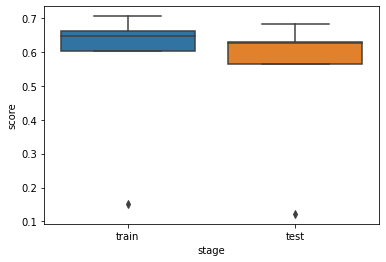

In [34]:
sns.boxplot(data = scores_df, x = 'stage', y = 'score')

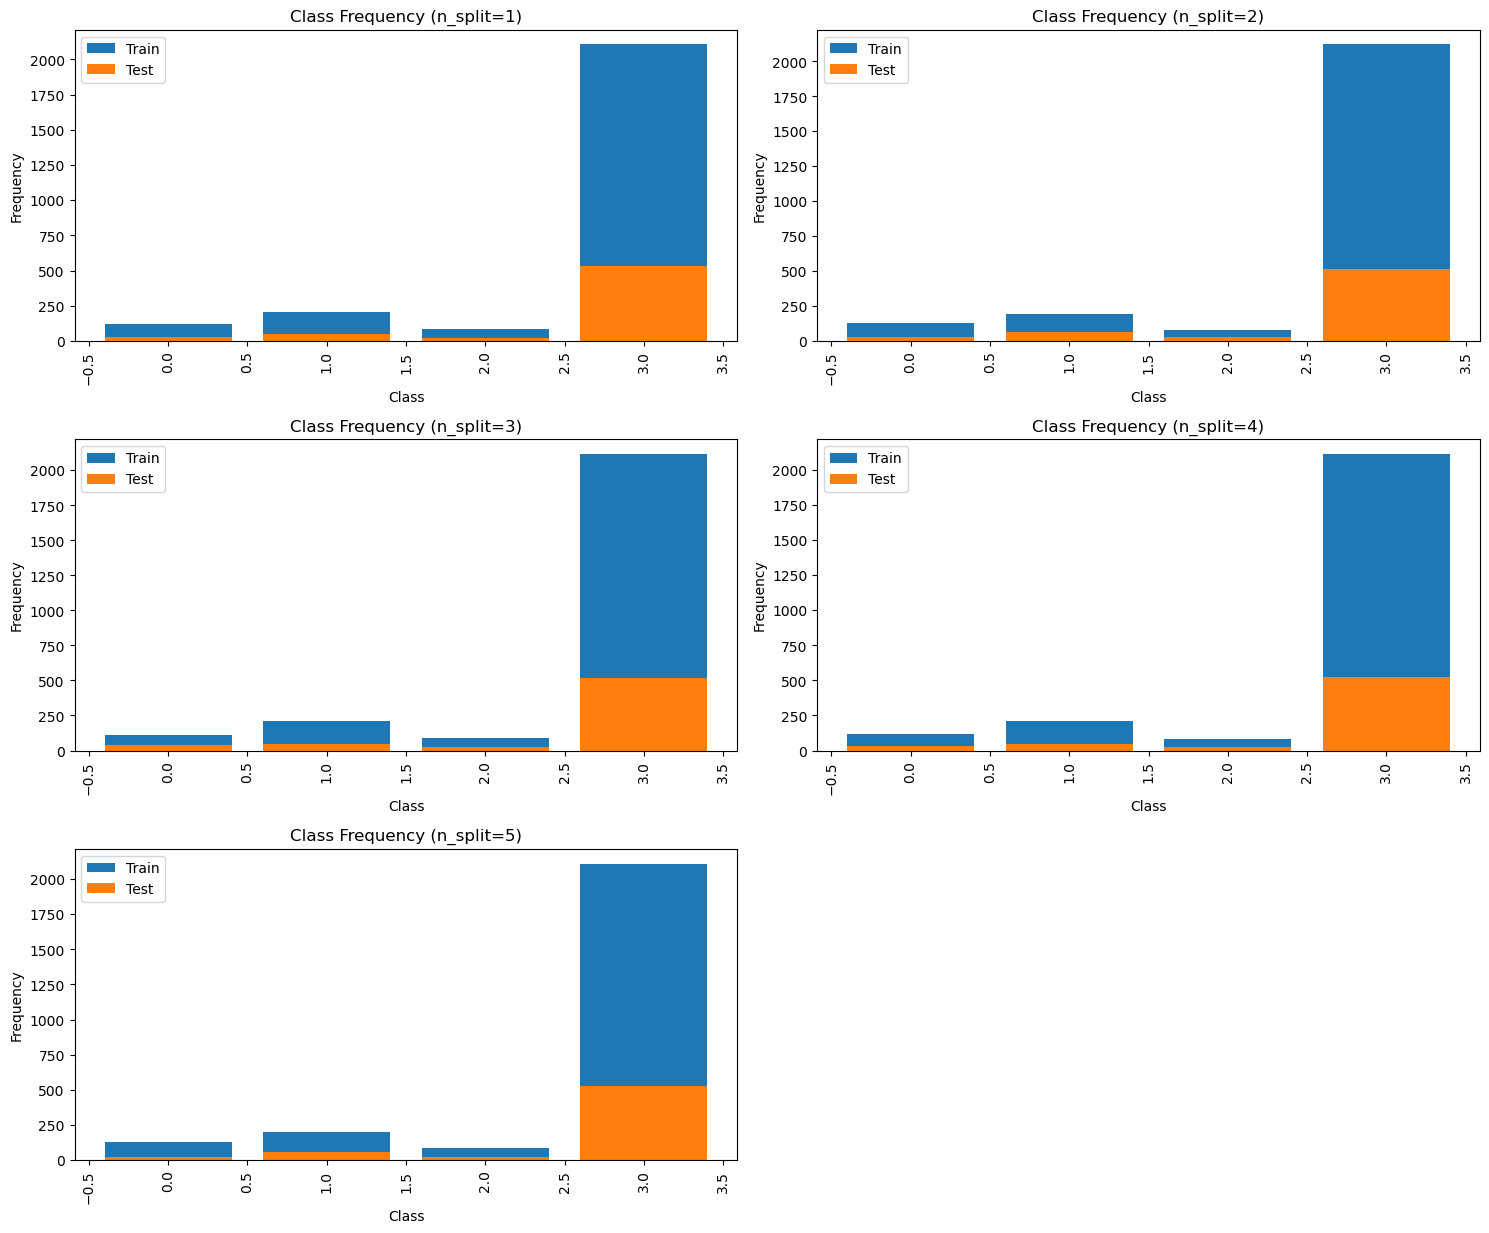

In [35]:
MyMultiTrainTester.plot_class_freq(normalize=True)

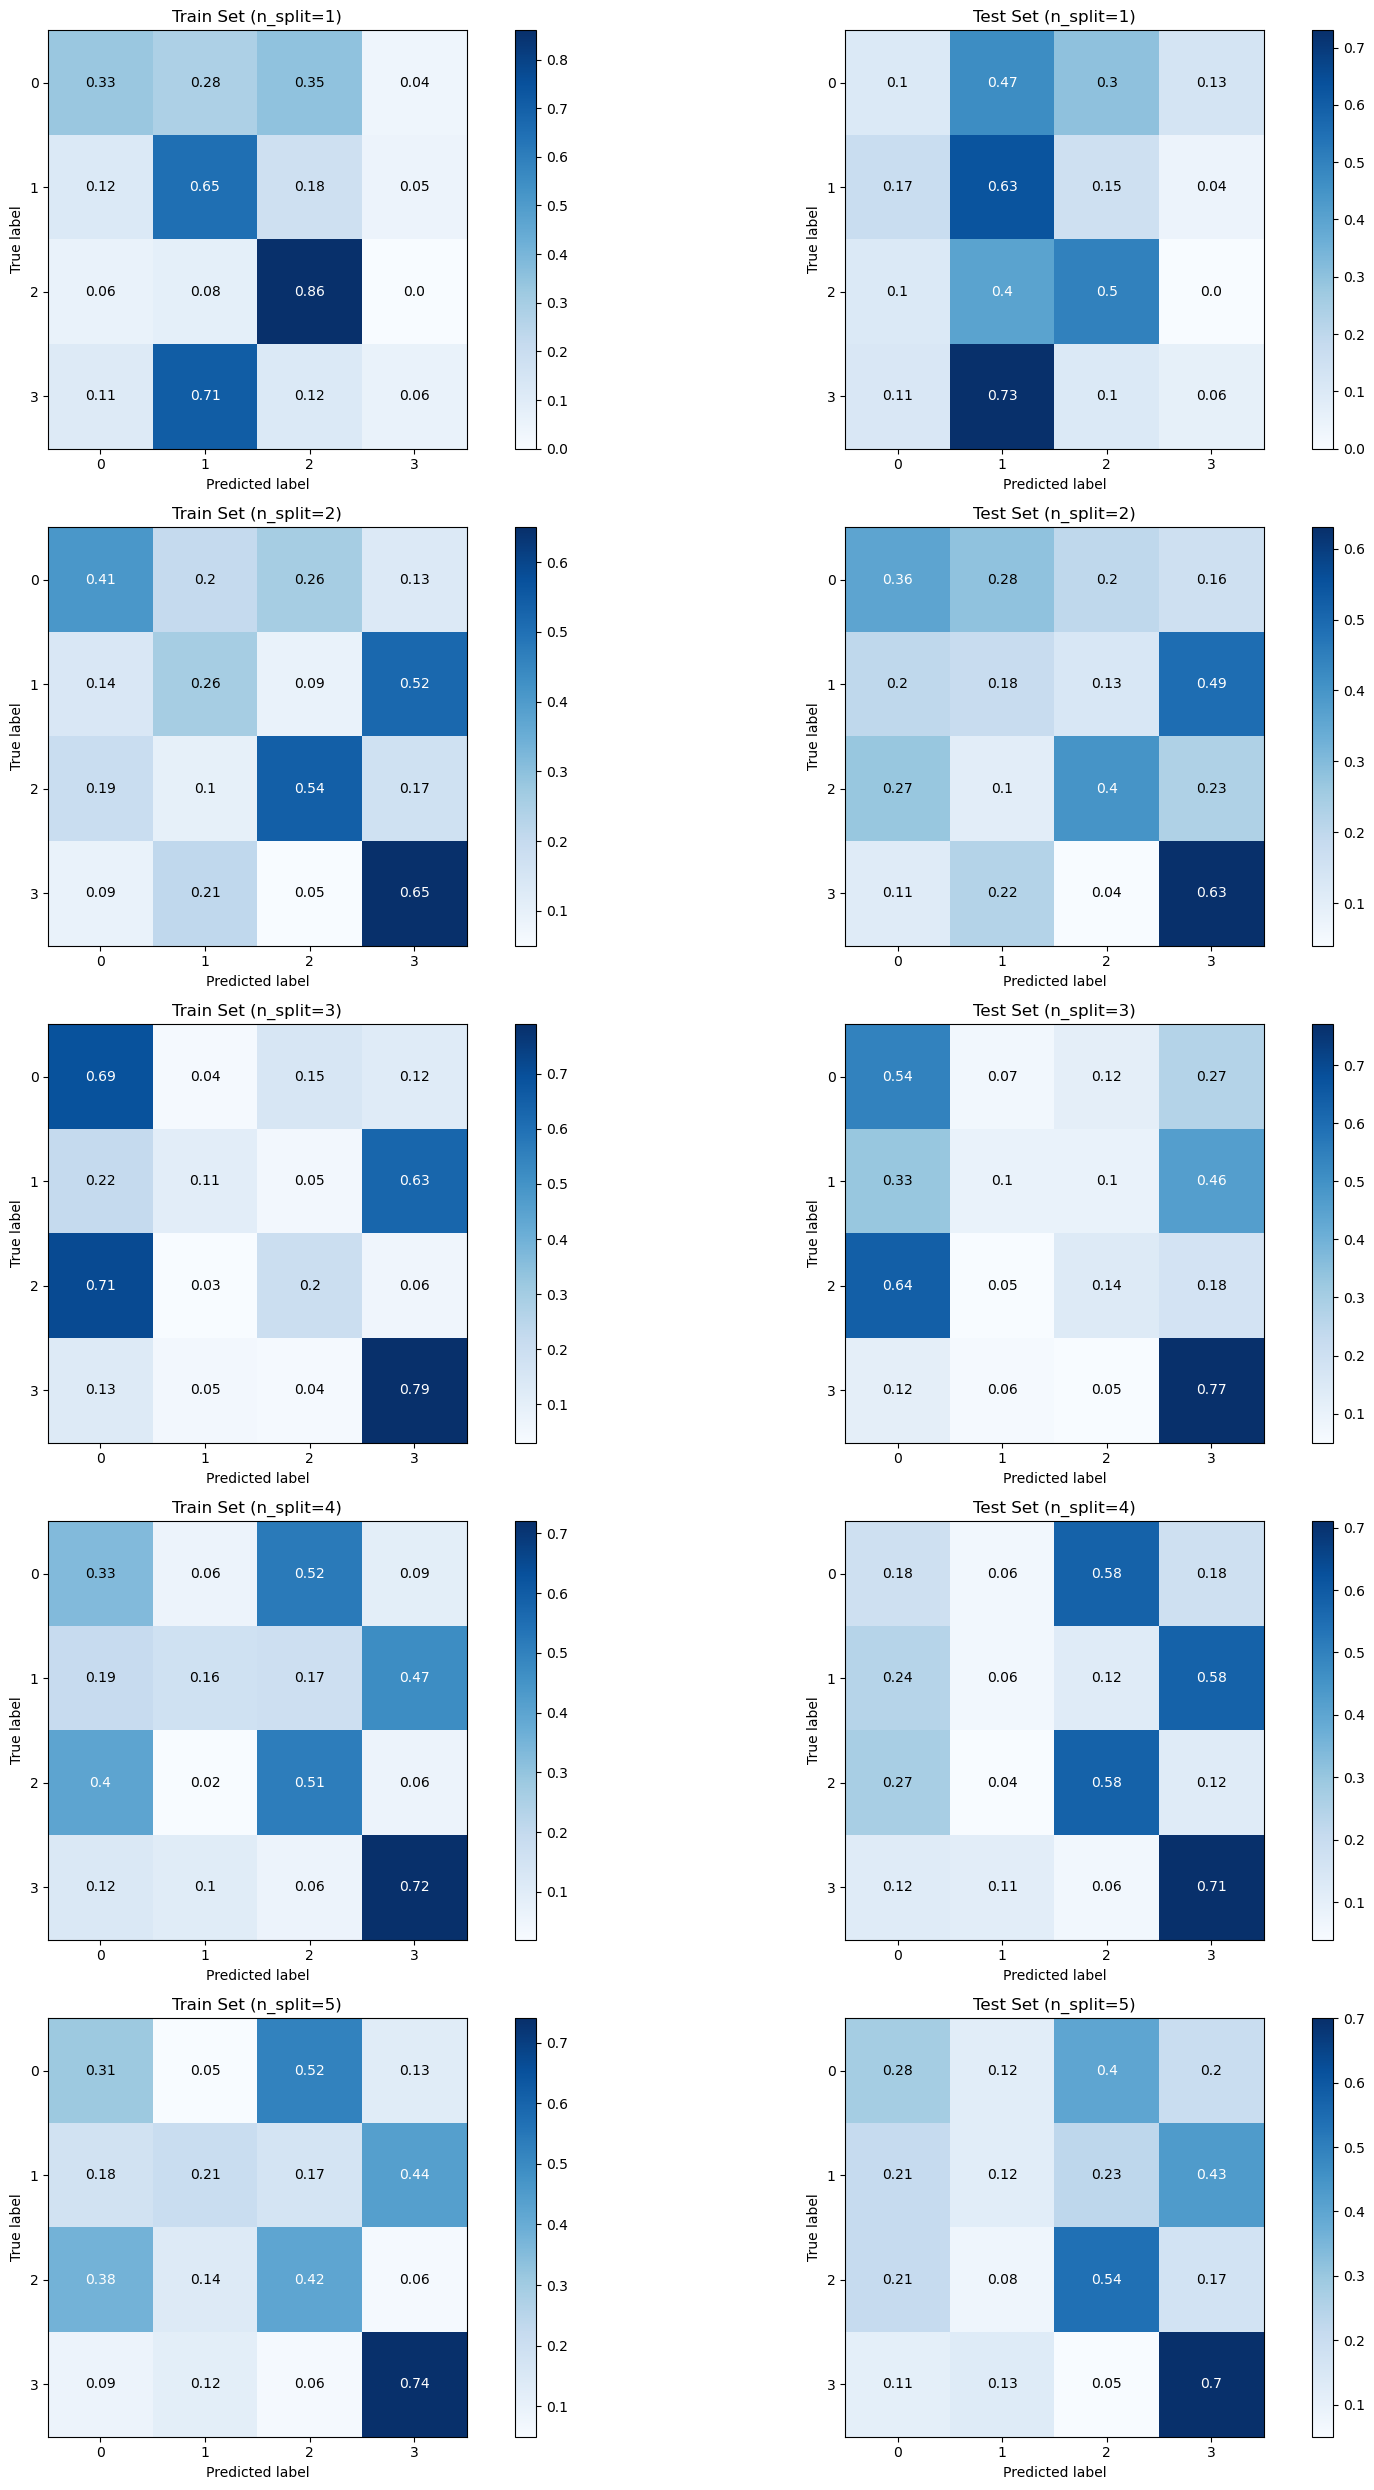

In [36]:
MyMultiTrainTester.plot_confusion(normalize=True)

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


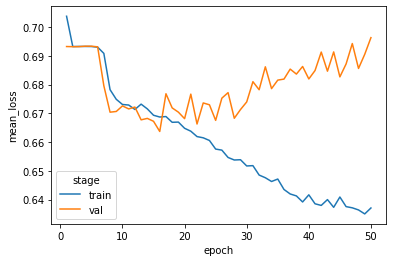

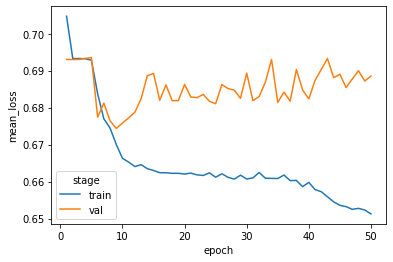

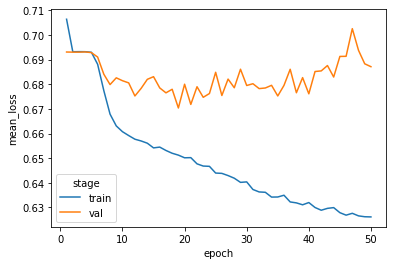

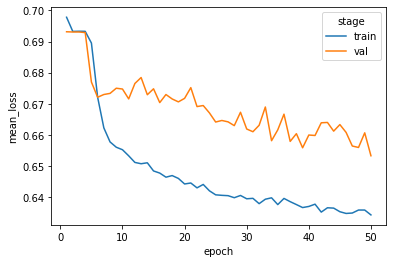

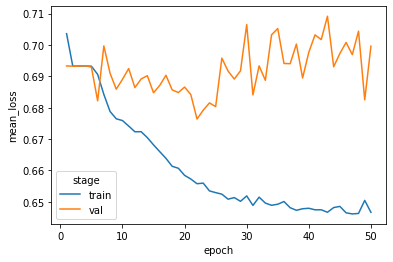

In [37]:
for i, trainer in enumerate(MyMultiTrainTester.TrainerList):
    plt.figure(i)
    print(sns.lineplot(data=trainer.model.TrainStats, x='epoch', y='mean_loss', hue = 'stage'))

### Examine Data In Encoded Space

In [38]:
best_model = np.argmax(MyMultiTrainTester.test_scores)
best_model

2

In [39]:
Trainer_use = MyMultiTrainTester.TrainerList[best_model]

In [40]:
X_transform = Trainer_use.transform_X(X)

In [41]:
X_encoded = Trainer_use.model.model.forward(torch.from_numpy(X_transform).to(torch.float32)).detach().numpy()

In [42]:
# X_encoded = MyFeedForward.forward(torch.from_numpy(X_transform).to(torch.float32)).detach().numpy()

In [43]:
X_encoded.shape

(3153, 2)

In [44]:
y_label = Trainer_use.model.one_hot.inverse_transform(y).astype('str')
y_pred = Trainer_use.model.predict(X_transform)
y_pred = Trainer_use.model.one_hot.inverse_transform(y_pred).astype('str')

In [45]:
X_enc_df = pd.DataFrame(X_encoded, columns = ['X' + str(i+1) for i in range(X_encoded.shape[1])])
X_enc_df['y'] = y_label
X_enc_df['y_pred'] = y_pred

In [46]:
X_enc_df

,X1,X2,y,y_pred
0,0.784050,1.009814,0,2
1,1.167540,1.185320,0,0
2,1.246695,1.219068,0,0
3,1.151070,1.155356,0,0
4,1.054834,1.145667,0,0
...,...,...,...,...
3148,0.488924,0.837184,3,3
3149,1.320695,1.372416,3,0
3150,0.204703,0.447650,3,3
3151,1.339778,1.327495,3,0


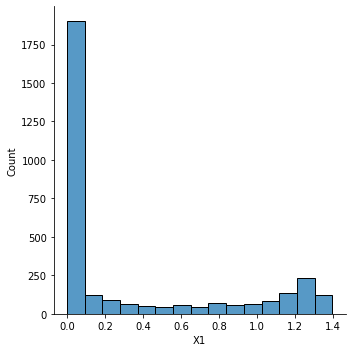

In [47]:
sns.displot(X_enc_df['X1'])

In [48]:
def do_plot(df, x, y, hue):
    if x in df.columns and y in df.columns and hue in df.columns:
        df_copy = df.copy(deep = True) 
        df_copy = df_copy.sort_values(by = hue)
        sns.scatterplot(data=df_copy, x=x, y=y, hue = hue)

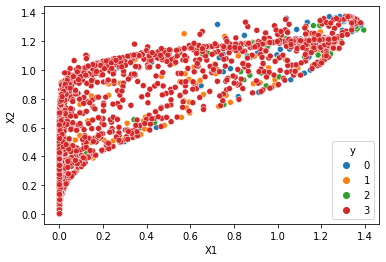

In [49]:
do_plot(X_enc_df, 'X1', 'X2', 'y')

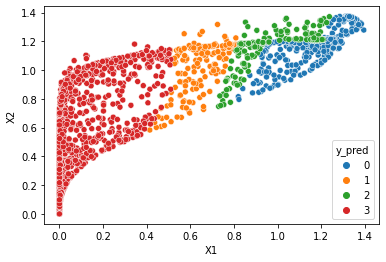

In [50]:
do_plot(X_enc_df, 'X1', 'X2', 'y_pred')

In [51]:
do_plot(X_enc_df, 'X2', 'X3', 'y')

In [52]:
do_plot(X_enc_df, 'X2', 'X3', 'y_pred')

In [53]:
do_plot(X_enc_df, 'X3', 'X4', 'y')

### Examine Misclassified Samples, or first sample if no misclassified samples

If no misclassified samples, show correcly classified sample

In [54]:
X_db = Trainer_use.model.ClassDB['X_encoded'].detach().numpy()
X_db.shape

(120, 2)

In [55]:
class_map

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [56]:
OneHot.inverse_transform(class_map)

array([['ACVD'],
       ['CRC'],
       ['Crohns disease'],
       ['Healthy']], dtype=object)

In [57]:
y_db = Trainer_use.model.ClassDB['y'].detach().numpy()
y_db = OneHot.inverse_transform(y_db).astype('str').flatten()

In [58]:
db_df = pd.DataFrame(X_db, columns = ['X' + str(i+1) for i in range(X_encoded.shape[1])])
db_df['y'] = y_db

In [59]:
db_df['y'].value_counts()

CRC               30
ACVD              30
Crohns disease    30
Healthy           30
Name: y, dtype: int64

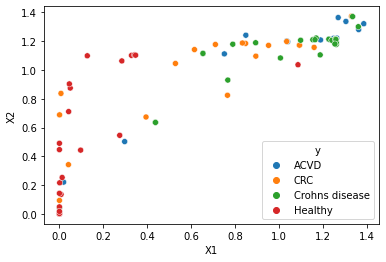

In [60]:
do_plot(db_df, 'X1', 'X2', 'y')

In [61]:
do_plot(db_df, 'X2', 'X3', 'y')

In [62]:
X_enc_df['misclassified'] = X_enc_df['y'] != X_enc_df['y_pred']

In [63]:
X_enc_df

,X1,X2,y,y_pred,misclassified
0,0.784050,1.009814,0,2,True
1,1.167540,1.185320,0,0,False
2,1.246695,1.219068,0,0,False
3,1.151070,1.155356,0,0,False
4,1.054834,1.145667,0,0,False
...,...,...,...,...,...
3148,0.488924,0.837184,3,3,False
3149,1.320695,1.372416,3,0,True
3150,0.204703,0.447650,3,3,False
3151,1.339778,1.327495,3,0,True


In [64]:
misclassified_idx = np.argwhere(X_enc_df['misclassified'].to_numpy()).flatten()
misclassified_idx

array([   0,    5,    6,    9,   21,   23,   24,   26,   34,   35,   39,
         41,   43,   46,   48,   50,   54,   55,   58,   59,   60,   63,
         65,   66,   69,   71,   72,   74,   75,   81,   86,   88,   90,
         92,   93,   98,  101,  103,  104,  105,  111,  116,  117,  120,
        123,  127,  132,  134,  135,  140,  144,  145,  149,  152,  153,
        154,  155,  156,  157,  158,  159,  160,  161,  162,  163,  164,
        165,  166,  167,  168,  169,  170,  171,  172,  173,  174,  175,
        177,  178,  179,  180,  181,  183,  185,  186,  187,  190,  191,
        192,  193,  194,  196,  197,  198,  199,  200,  201,  202,  203,
        206,  208,  209,  210,  211,  212,  213,  214,  215,  216,  217,
        218,  219,  220,  221,  222,  223,  224,  225,  226,  227,  228,
        229,  230,  231,  232,  233,  234,  235,  236,  237,  238,  239,
        240,  241,  242,  243,  245,  246,  247,  248,  249,  250,  251,
        252,  253,  254,  255,  256,  257,  258,  2

In [65]:
if len(misclassified_idx) == 0:
    idx_use = 0
else:
    idx_use = misclassified_idx[0]
    
X_diff = torch.abs(torch.from_numpy(X_encoded[idx_use, :] - X_db).to(torch.float32))
logistic_output = Trainer_use.model.logistic.forward(X_diff)

In [66]:
X_diff_df = pd.DataFrame(X_diff, columns = ['X' + str(i+1) + '_diff' for i in range(X_diff.shape[1])])
X_diff_df['y'] = y_db

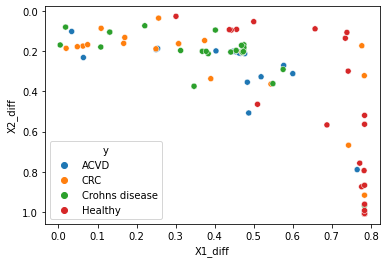

In [67]:
do_plot(X_diff_df, 'X1_diff', 'X2_diff', 'y')

In [68]:
do_plot(X_diff_df, 'X2_diff', 'X3_diff', 'y')

In [69]:
logistic_output[y_db == 'Healthy', 1]

tensor([0.4544, 0.3746, 0.4271, 0.4548, 0.4286, 0.4548, 0.4978, 0.4548, 0.4339,
        0.4669, 0.4548, 0.4548, 0.4548, 0.4516, 0.4547, 0.4548, 0.3497, 0.4160,
        0.5265, 0.4548, 0.4238, 0.3548, 0.3669, 0.3259, 0.4458, 0.4648, 0.4151,
        0.4569, 0.4544, 0.3194], grad_fn=<IndexBackward>)

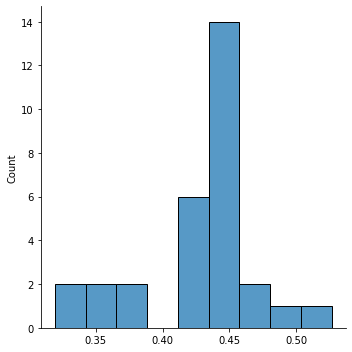

In [70]:
sns.displot(logistic_output[y_db == 'Healthy', 1].detach().numpy())

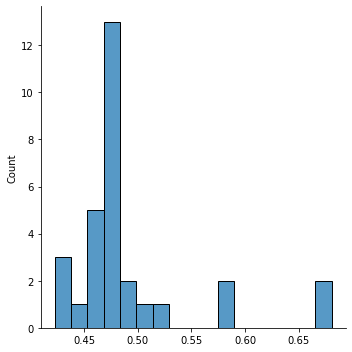

In [71]:
sns.displot(logistic_output[y_db == 'ACVD', 1].detach().numpy())

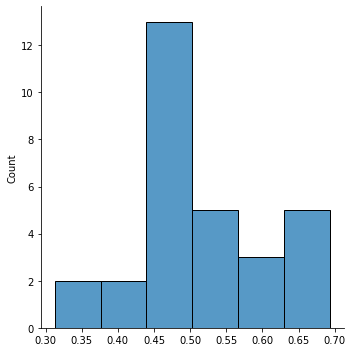

In [72]:
sns.displot(logistic_output[y_db == 'CRC', 1].detach().numpy())

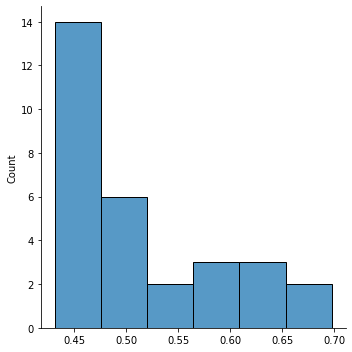

In [73]:
sns.displot(logistic_output[y_db == 'Crohns disease', 1].detach().numpy())

We're doing a little better than before when it comes to not classifying EVERYTHING as healthy. It may well be that a doing a bunch of separate binary classication tasks is far easier